In [1]:
#For data
import pandas as pd
import numpy as np

In [2]:
#For Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches

In [3]:
#For Stationary Test
import statsmodels.api as sm

In [4]:
#For Outliers detection, Model tuning, Clustering
from sklearn import preprocessing, svm, model_selection, metrics, cluster

In [5]:
#For Autoregressive Models
from tensorflow.keras import models, layers, preprocessing as kprocessing

In [6]:
#For Prophet
#from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

In [7]:
#For parametric fit and resistance/support
from scipy import optimize, stats, signal, cluster as sci_cluster

In [8]:
#For Clustering
from tslearn.metrics import dtw
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

In [9]:
#!pip install tslearn

## Time Series - Clustering

#### Walmart dataset

In [10]:
import warnings
warnings.filterwarnings("ignore")
import datetime

In [11]:
dtf=pd.read_csv("E:\Data Science\Time Series\data_multiple.csv")
dtf.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_3_536_CA_1_validation,FOODS_3_536,FOODS_3,FOODS,CA_1,CA,3,2,2,4,...,3,1,0,3,0,0,2,1,2,1
1,FOODS_3_382_CA_3_validation,FOODS_3_382,FOODS_3,FOODS,CA_3,CA,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,HOUSEHOLD_1_375_WI_1_validation,HOUSEHOLD_1_375,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,1,0,0,1,...,0,0,2,1,0,1,0,1,2,1
3,FOODS_2_084_CA_3_validation,FOODS_2_084,FOODS_2,FOODS,CA_3,CA,0,0,0,0,...,1,1,1,2,4,3,1,1,6,1
4,FOODS_3_668_CA_1_validation,FOODS_3_668,FOODS_3,FOODS,CA_1,CA,22,9,7,12,...,10,10,8,8,9,10,6,6,10,6


In [12]:
# Randomnly reduce number of ts
dtf=dtf.drop_duplicates("item_id", keep='first').head(1000).reset_index(drop=True)
dtf=dtf.drop(["id", "dept_id", "state_id", "store_id"], axis=1)
dtf.head()

,item_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_3_536,FOODS,3,2,2,4,0,0,2,3,...,3,1,0,3,0,0,2,1,2,1
1,FOODS_3_382,FOODS,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,HOUSEHOLD_1_375,HOUSEHOLD,1,0,0,1,0,1,2,3,...,0,0,2,1,0,1,0,1,2,1
3,FOODS_2_084,FOODS,0,0,0,0,0,0,0,0,...,1,1,1,2,4,3,1,1,6,1
4,FOODS_3_668,FOODS,22,9,7,12,17,20,13,29,...,10,10,8,8,9,10,6,6,10,6


In [13]:
# Create date list
cols=dtf.filter(like="d_", axis=1).columns.tolist()
dates=pd.date_range(start=(datetime.datetime.now() - datetime.timedelta(days=len(cols)-1)).strftime("%Y-%m-%d"),
                   end=datetime.datetime.now().strftime("%Y-%m-%d"),
                   freq='D').astype(str).tolist()
print(dates[0:5],"...", dates[-1])

['2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03', '2019-09-04'] ... 2024-11-24


In [14]:
# Rename columns
dtf.columns = ["ts", "exog"] + dates
dtf.head()

,ts,exog,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,...,2024-11-15,2024-11-16,2024-11-17,2024-11-18,2024-11-19,2024-11-20,2024-11-21,2024-11-22,2024-11-23,2024-11-24
0,FOODS_3_536,FOODS,3,2,2,4,0,0,2,3,...,3,1,0,3,0,0,2,1,2,1
1,FOODS_3_382,FOODS,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,HOUSEHOLD_1_375,HOUSEHOLD,1,0,0,1,0,1,2,3,...,0,0,2,1,0,1,0,1,2,1
3,FOODS_2_084,FOODS,0,0,0,0,0,0,0,0,...,1,1,1,2,4,3,1,1,6,1
4,FOODS_3_668,FOODS,22,9,7,12,17,20,13,29,...,10,10,8,8,9,10,6,6,10,6


### Functions

###### TS Analysis

In [15]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='ts', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window), color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [16]:
def fit_trend(ts, degree=1, plot=True, figsize=(15,5)):
    ## fit trend
    dtf = ts.to_frame(name="ts")
    params = np.polyfit(ts.reset_index().index, ts.values, deg=degree)
    costant = params[-1]    
    dtf["trend"] = costant
    X = np.array(range(1,len(ts)+1))
    for i in range(1,degree+1):
        dtf["trend"] = dtf["trend"] + params[i-1]*(X**i)
        
    ## plot
    if plot is True:
        ax = dtf.plot(grid=True, title="Fitting Trend", figsize=figsize, color=["black","red"])
        ax.set(xlabel=None)
        plt.show()
    return dtf, params

In [17]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=(15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))
        
        ## plot ts with mean/std of a sample from the first x% 
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red", linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'], y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax, legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index, y1=dtf_ts['lower'].head(sample_size), y2=dtf_ts['upper'].head(sample_size), color='lightskyblue')
        ts_ax.set(xlabel=None)

        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag, autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+' (p-value: '+str(p)+')')
        
        ## pacf (for AR) e acf (for MA) 
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax, title="Autocorrelation (for MA component)")
        plt.tight_layout()  

In [18]:
def diff_ts(ts, lag=1, order=1, drop_na=True):
    for i in range(order):
        ts = ts - ts.shift(lag)
    ts = ts[(pd.notnull(ts))] if drop_na is True else ts.fillna(method="bfill")
    return ts

In [19]:
def undo_diff(ts, first_y, lag=1, order=1):
    for i in range(order):
        (24168.04468 - 18256.02366) + a.cumsum()
        ts = np.r_[ts, ts[lag:]].cumsum()
    return ts

In [20]:
def test_2ts_casuality(ts1, ts2, maxlag=30, figsize=(15,5)):
    ## prepare
    dtf = ts1.to_frame(name=ts1.name)
    dtf[ts2.name] = ts2
    dtf.plot(figsize=figsize, grid=True, title=ts1.name+"  vs  "+ts2.name)
    plt.show()
    ## test casuality (Granger test) 
    granger_test = sm.tsa.stattools.grangercausalitytests(dtf, maxlag=maxlag, verbose=False)
    for lag,tupla in granger_test.items():
        p = np.mean([tupla[0][k][1] for k in tupla[0].keys()])
        p = round(p, 3)
        if p < 0.05:
            conclusion = "Casuality with lag "+str(lag)+" (p-value: "+str(p)+")"
            print(conclusion)

In [21]:
def decompose_ts(ts, s=7, figsize=(20,13)):
    decomposition = smt.seasonal_decompose(ts, freq=s)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid   
    fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=figsize)
    ax[0].plot(ts)
    ax[0].set_title('Original')
    ax[0].grid(True) 
    ax[1].plot(trend)
    ax[1].set_title('Trend')
    ax[1].grid(True)  
    ax[2].plot(seasonal)
    ax[2].set_title('Seasonality')
    ax[2].grid(True)  
    ax[3].plot(residual)
    ax[3].set_title('Residuals')
    ax[3].grid(True)
    return {"trend":trend, "seasonal":seasonal, "residual":residual}

In [22]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda x: 1 if x == -1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found "+str(sum(dtf_outliers["outlier"] == 1)))
    ax.plot(dtf_outliers.index, dtf_outliers["ts"], color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1].index, y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'], color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers


In [23]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5, title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black", label="interpolated", legend=True)
    ax.set(xlabel=None)
    plt.show()
    return ts_clean

In [24]:
def resistence_support(ts, window=30, trend=False, plot=True, figsize=(15,5)):
    dtf = ts.to_frame(name="ts")
    dtf["max"], dtf["min"] = [np.nan, np.nan]
    rolling = dtf['ts'].rolling(window=window).mean().dropna()  

    ## maxs
    local_max = signal.argrelextrema(rolling.values, np.greater)[0]
    local_max_idx = [dtf.iloc[i-window:i+window]['ts'].idxmax() for i in local_max if (i > window) and (i < len(dtf)-window)]
    dtf["max"].loc[local_max_idx] = dtf["ts"].loc[local_max_idx]

    ## mins
    local_min = signal.argrelextrema(rolling.values, np.less)[0]
    local_min_idx = [dtf.iloc[i-window:i+window]['ts'].idxmin() for i in local_min if (i > window) and (i < len(dtf)-window)]
    dtf["min"].loc[local_min_idx] = dtf["ts"].loc[local_min_idx]

    ## resistence/support
    dtf["resistence"] = dtf["max"].interpolate(method="linear") if trend is True else dtf["max"].fillna(method="ffill")
    dtf["support"] = dtf["min"].interpolate(method="linear") if trend is True else dtf["min"].fillna(method="ffill")
    
    ## plot
    if plot is True:
        ax = dtf["ts"].plot(color="black", figsize=figsize, grid=True, title="Resistence and Support")
        dtf["resistence"].plot(ax=ax, color="darkviolet", label="resistence", grid=True, linestyle="--")
        dtf["support"].plot(ax=ax, color="green", label="support", grid=True, linestyle="--")
        ax.scatter(x=dtf["max"].index, y=dtf["max"].values, color="darkviolet", label="max")
        ax.scatter(x=dtf["min"].index, y=dtf["min"].values, color="green", label="min")
        ax.set(xlabel=None)
        ax.legend()
        plt.show()
    return dtf


###### Model Design & Testing

In [25]:
def split_train_test(ts, exog=None, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    ## split exog
    if exog is not None:
        exog_train = exog[0:split] 
        exog_test = exog[split:]
        return ts_train, ts_test, exog_train, exog_test
    else:
        return ts_train, ts_test

In [26]:
def utils_conf_int(lst_values, error_std, conf=0.95):
    lst_values = list(lst_values) if type(lst_values) != list else lst_values
    c = round( stats.norm.ppf(1-(1-conf)/2), 2)
    lst_ci = []
    for x in lst_values:
        lst_x = lst_values[:lst_values.index(x)+1]
        h = len(lst_x)
        ci = [x - (c*error_std*np.sqrt(h)), x + (c*error_std*np.sqrt(h))]
        lst_ci.append(ci)
    return np.array(lst_ci)

In [27]:
def utils_evaluate_ts_model(dtf, conf=0.95, title=None, plot=True, figsize=(20,13)):
    try:
        ## residuals from fitting
        ### add column
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        ### kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()

        ## forecasting error
        ### add column
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        ### kpi
        error_mean = dtf["error"].mean() 
        error_std = dtf["error"].std() 
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()  #mean absolute error
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  #mean absolute error %
        mse = dtf["error"].apply(lambda x: x**2).mean()  #mean squared error
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## interval
        if "upper" not in dtf.columns:
            print("--- computing confidence interval ---")
            dtf["lower"], dtf["upper"] = [np.nan, np.nan]
            dtf.loc[dtf["forecast"].notnull(), ["lower","upper"]] = utils_conf_int(
                dtf[dtf["forecast"].notnull()]["forecast"], residuals_std, conf)
        
        ## plot
        if plot is True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Train (obs: "+str(len(dtf[pd.notnull(dtf["model"])]))+")", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Test (obs: "+str(len(dtf[pd.isnull(dtf["model"])]))+")", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['lower'], y2=dtf['upper'], color='b', alpha=0.2)
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.axvline(dtf["residuals"].mean(), ls='--', color="green", label="mean: "+str(round(dtf["residuals"].mean(),2)))
            ax4.axvline(dtf["error"].mean(), ls='--', color="red", label="mean: "+str(round(dtf["error"].mean(),2)))
            ax4.set(ylabel=None)
            ax4.legend()
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts", "model", "residuals", "lower", "forecast", "upper", "error"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)
    

In [28]:
def utils_generate_indexdate(start, end=None, n=None, freq="D"):
    if end is not None:
        index = pd.date_range(start=start, end=end, freq=freq)
    else:
        index = pd.date_range(start=start, periods=n, freq=freq)
    index = index[1:]
    print("--- generating index date --> freq:", freq, "| start:", index[0], "| end:", index[-1], "| len:", len(index), "---")
    return index

In [29]:
def utils_add_forecast_int(dtf, conf=0.95, plot=True, zoom=30, figsize=(15,5)):
    ## residuals from fitting
    ### add column
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    ### kpi
    residuals_std = dtf["residuals"].std()
    
    ## interval
    if "upper" not in dtf.columns:
        print("--- computing confidence interval ---")
        dtf["lower"], dtf["upper"] = [np.nan, np.nan]
        dtf.loc[dtf["forecast"].notnull(), ["lower","upper"]] = utils_conf_int(
            dtf[dtf["forecast"].notnull()]["forecast"], residuals_std, conf)

    ## plot
    if plot is True:
        fig = plt.figure(figsize=figsize)
        
        ### entire series
        ax0 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan=2)
        dtf[["ts","forecast"]].plot(color=["black","red"], grid=True, ax=ax0, title="History + Future")
        ax0.fill_between(x=dtf.index, y1=dtf['lower'], y2=dtf['upper'], color='b', alpha=0.2)
        ax0.set(xlabel=None)

        ### focus on last
        ax1 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan=1)
        first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
        first_loc = dtf.index.tolist().index(first_idx)
        zoom_idx = dtf.index[first_loc-zoom]
        dtf.loc[zoom_idx:][["ts","forecast"]].plot(color=["black","red"], grid=True, ax=ax1, title="Zoom on the last "+str(zoom)+" observations")
        ax1.fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['lower'], y2=dtf.loc[zoom_idx:]['upper'], color='b', alpha=0.2)
        ax1.set(xlabel=None)
        plt.show()
    return dtf[["ts", "model", "residuals", "lower", "forecast", "upper"]]

###### Random Walk

In [30]:
def utils_generate_rw(y0, n, sigma, ymin=None, ymax=None):
    rw = [y0]
    for t in range(1, n):
        yt = rw[t-1] + np.random.normal(0,sigma)
        if (ymax is not None) and (yt > ymax):
            yt = rw[t-1] - abs(np.random.normal(0,sigma))
        elif (ymin is not None) and (yt < ymin):
            yt = rw[t-1] + abs(np.random.normal(0,sigma))
        rw.append(yt)
    return rw

In [31]:
def simulate_rw(ts_train, ts_test, conf=0.95, figsize=(15,10)):
    ## simulate train
    diff_ts = ts_train - ts_train.shift(1)
    rw = utils_generate_rw(y0=ts_train[0], n=len(ts_train), sigma=diff_ts.std(), ymin=ts_train.min(), ymax=ts_train.max())
    dtf_train = ts_train.to_frame(name="ts").merge(pd.DataFrame(rw, index=ts_train.index, columns=["model"]), how='left', left_index=True, right_index=True)
    
    ## test
    rw = utils_generate_rw(y0=ts_train[-1], n=len(ts_test), sigma=diff_ts.std(), ymin=ts_train.min(), ymax=ts_train.max())
    dtf_test = ts_test.to_frame(name="ts").merge(pd.DataFrame(rw, index=ts_test.index, columns=["forecast"]), 
                                                 how='left', left_index=True, right_index=True)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title="Random Walk Simulation")
    return dtf



'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param end: string - date to forecast (ex. end="2016-12-31")
    :param zoom: for plotting
:return
    dtf with columns "ts", "model", "residuals", "lower", "forecast", "upper" (No error)
'''
def forecast_rw(ts, pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## fit
    diff_ts = ts - ts.shift(1)
    sigma = diff_ts.std()
    rw = utils_generate_rw(y0=ts[0], n=len(ts), sigma=sigma, ymin=ts.min(), ymax=ts.max())
    dtf = ts.to_frame(name="ts").merge(pd.DataFrame(rw, index=ts.index, columns=["model"]), 
                                       how='left', left_index=True, right_index=True)
    
    ## index
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    preds = utils_generate_rw(y0=ts[-1], n=len(index), sigma=sigma, ymin=ts.min(), ymax=ts.max())
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## add intervals and plot
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf

###### Autoregressive

In [32]:
def tune_expsmooth_model(ts_train, s=7, val_size=0.2, scoring=None, top=None, figsize=(15,5)):
    ## split
    dtf_fit, dtf_val = model_selection.train_test_split(ts_train, test_size=val_size, shuffle=False)
    dtf_fit, dtf_val = dtf_fit.to_frame(name="ts"), dtf_val.to_frame(name="ts")
    
    ## scoring
    scoring = metrics.mean_absolute_error if scoring is None else scoring   
    
    ## hyperamater space
    trend = ['add', 'mul', None]
    damped = [True, False]
    seasonal = ['add', 'mult', None]

    ## grid search
    freq = ts_train.index.inferred_freq[0]
    dtf_search = pd.DataFrame(columns=["combo","score","model"])
    combinations = []
    for t in trend:
        for d in damped:
            for ss in seasonal:
                combo = "trend="+str(t)+", damped="+str(d)+", seas="+str(ss)
                if combo not in combinations:
                    combinations.append(combo)
                    try:
                        ### fit
                        model = smt.ExponentialSmoothing(dtf_fit, trend=t, damped=d, seasonal=ss, seasonal_periods=s, freq=freq).fit()
                        ### predict
                        pred =  model.forecast(len(dtf_val))
                        if pred.isna().sum() == 0:
                            dtf_val[combo] = pred.values
                            score = scoring(dtf_val["ts"].values, dtf_val[combo].values)
                            dtf_search = dtf_search.append(pd.DataFrame({"combo":[combo],"score":[score],"model":[model]}))
                    except:
                        continue
    
    ## find best
    dtf_search = dtf_search.sort_values("score").reset_index(drop=True)
    best = dtf_search["combo"].iloc[0]
    dtf_val = dtf_val.rename(columns={best:best+" [BEST]"})
    dtf_val = dtf_val[["ts",best+" [BEST]"] + list(dtf_search["combo"].unique())[1:]]
    
    ## plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle("Model Tuning", fontsize=15)
    combos = dtf_val.drop("ts", axis=1).columns[:top]
    if (len(combos) <= 7) or ((top is not None) and (top <= 7)):
        colors = ["red","blue","green","violet","sienna","orange","yellow"]
    else: 
        colors = [tuple(np.random.rand(3,)) for i in range(len(combos))]

    ### main
    ts_train.plot(ax=ax[0], grid=True, color="black", legend=True, label="ts")
    ax[0].fill_between(x=dtf_fit.index, y1=ts_train.max(), color='grey', alpha=0.2)
    dtf_val[combos].plot(grid=True, ax=ax[0], color=colors, legend=True)
    ax[0].legend(loc="upper left")
    ax[0].set(xlabel=None)
    ### zoom
    dtf_val["ts"].plot(grid=True, ax=ax[1], color="black", legend=False) 
    for i,col in enumerate(combos):
        linewidth = 2 if col == best+" [BEST]" else 1
        dtf_val[col].plot(grid=True, ax=ax[1], color=colors[i], legend=False, linewidth=linewidth)
    ax[1].set(xlabel=None)  
    plt.show()
    return dtf_search

In [33]:
def fit_expsmooth(ts_train, ts_test, trend="additive", damped=False, seasonal="multiplicative", s=None, factors=(None,None,None), conf=0.95, figsize=(15,10)):
    ## checks
    check_seasonality = "Seasonal parameters: No Seasonality" if (seasonal is None) & (s is None) else "Seasonal parameters: "+str(seasonal)+" Seasonality every "+str(s)+" observations"
    print(check_seasonality)
    
    ## train
    freq = ts_train.index.inferred_freq[0]
    model = smt.ExponentialSmoothing(ts_train, trend=trend, damped=damped, seasonal=seasonal, seasonal_periods=s, freq=freq).fit(factors[0], factors[1], factors[2])
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.predict(start=len(ts_train), end=len(ts_train)+len(ts_test)-1)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    alpha, beta, gamma = round(model.params["smoothing_level"],2), round(model.params["smoothing_slope"],2), round(model.params["smoothing_seasonal"],2)
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title="Holt-Winters "+str((alpha, beta, gamma)))
    return dtf, model

In [34]:
def tune_arima_model(ts_train, s=7, val_size=0.2, max_order=(3,1,3), seasonal_order=(1,1,1), scoring=None, top=None, figsize=(15,5)):
    ## split
    dtf_fit, dtf_val = model_selection.train_test_split(ts_train, test_size=val_size, shuffle=False)
    dtf_fit, dtf_val = dtf_fit.to_frame(name="ts"), dtf_val.to_frame(name="ts")
    
    ## scoring
    scoring = metrics.mean_absolute_error if scoring is None else scoring   
    
    ## hyperamater space
    ps = range(0,max_order[0]+1)
    ds = range(0,max_order[1]+1)
    qs = range(0,max_order[2]+1)
    Ps = range(0,seasonal_order[0]+1)
    Ds = range(0,seasonal_order[1]+1)
    Qs = range(0,seasonal_order[2]+1)

    ## grid search
    dtf_search = pd.DataFrame(columns=["combo","score","model"])
    combinations = []
    for p in ps:
        for d in ds:
            for q in qs:
                for P in Ps:
                    for D in Ds:
                        for Q in Qs:
                            combo = "("+str(p)+","+str(d)+","+str(q)+")x("+str(P)+","+str(D)+","+str(Q)+")"
                            if combo not in combinations:
                                combinations.append(combo)
                            try:
                                ### fit
                                model = smt.SARIMAX(ts_train, order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
                                ### predict
                                pred =  model.forecast(len(dtf_val))
                                if pred.isna().sum() == 0:
                                    dtf_val[combo] = pred.values
                                    score = scoring(dtf_val["ts"].values, dtf_val[combo].values)
                                    dtf_search = dtf_search.append(pd.DataFrame({"combo":[combo],"score":[score],"model":[model]}))
                            except:
                                continue
    
    ## find best
    dtf_search = dtf_search.sort_values("score").reset_index(drop=True)
    best = dtf_search["combo"].iloc[0]
    dtf_val = dtf_val.rename(columns={best:best+" [BEST]"})
    dtf_val = dtf_val[["ts",best+" [BEST]"] + list(dtf_search["combo"].unique())[1:]]
    
    ## plot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle("Model Tuning", fontsize=15)
    combos = dtf_val.drop("ts", axis=1).columns[:top]
    if (len(combos) <= 7) or ((top is not None) and (top <= 7)):
        colors = ["red","blue","green","violet","sienna","orange","yellow"]
    else: 
        colors = [tuple(np.random.rand(3,)) for i in range(len(combos))]

    ### main
    ts_train.plot(ax=ax[0], grid=True, color="black", legend=True, label="ts")
    ax[0].fill_between(x=dtf_fit.index, y1=ts_train.max(), color='grey', alpha=0.2)
    dtf_val[combos].plot(grid=True, ax=ax[0], color=colors, legend=True)
    ax[0].legend(loc="upper left")
    ax[0].set(xlabel=None)
    ### zoom
    dtf_val["ts"].plot(grid=True, ax=ax[1], color="black", legend=False) 
    for i,col in enumerate(combos):
        linewidth = 2 if col == best+" [BEST]" else 1
        dtf_val[col].plot(grid=True, ax=ax[1], color=colors[i], legend=False, linewidth=linewidth)
    ax[1].set(xlabel=None)  
    plt.show()
    return dtf_search


In [35]:
def find_best_sarimax(ts, seasonal=True, stationary=False, s=1, exog=None,
                      max_p=10, max_d=3, max_q=10,
                      max_P=10, max_D=3, max_Q=10):
    best_model = pmdarima.auto_arima(ts, exogenous=exog,
                                     seasonal=seasonal, stationary=stationary, m=s, 
                                     information_criterion='aic', max_order=20,
                                     max_p=max_p, max_d=max_d, max_q=max_q,
                                     max_P=max_P, max_D=max_D, max_Q=max_Q,
                                     error_action='ignore')
    print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)
    return best_model.summary()

In [36]:
def fit_sarimax(ts_train, ts_test, order=(1,0,1), seasonal_order=(1,0,1), s=7, exog_train=None, exog_test=None, conf=0.95, figsize=(15,10)):
    ## checks
    check_trend = "Trend parameters: No differencing" if order[1] == 0 else "Trend parameters: d="+str(order[1])
    print(check_trend)
    check_seasonality = "Seasonal parameters: No Seasonality" if (s == 0) & (np.sum(seasonal_order[0:2]) == 0) else "Seasonal parameters: Seasonality every "+str(s)+" observations"
    print(check_seasonality)
    check_exog = "Exog parameters: Not given" if (exog_train is None) & (exog_test is None) else "Exog parameters: number of regressors="+str(exog_train.shape[1])
    print(check_exog)
    
    ## train
    model = smt.SARIMAX(ts_train, order=order, seasonal_order=seasonal_order+(s,), exog=exog_train, enforce_stationarity=False, enforce_invertibility=False).fit()
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.predict(start=len(ts_train), end=len(ts_train)+len(ts_test)-1, exog=exog_test)

    ## add conf_int
    ci = model.get_forecast(len(ts_test)).conf_int(1-conf).values
    dtf_test["lower"], dtf_test["upper"] = ci[:,0], ci[:,1]
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "ARIMA "+str(order) if exog_train is None else "ARIMAX "+str(order)
    title = "S"+title+" x "+str(seasonal_order) if np.sum(seasonal_order) > 0 else title
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title=title)
    return dtf, model

In [37]:
def fit_garch(ts_train, ts_test, order=(1,0,1), seasonal_order=(0,0,0,0), exog_train=None, exog_test=None, figsize=(15,10)):
    ## train
    arima = smt.SARIMAX(ts_train, order=order, seasonal_order=seasonal_order, exog=exog_train, enforce_stationarity=False, enforce_invertibility=False).fit()
    garch = arch.arch_model(arima.resid, p=order[0], o=order[1], q=order[2], x=exog_train, dist='StudentsT', power=2.0, mean='Constant', vol='GARCH')
    model = garch.fit(update_freq=seasonal_order[3])
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.conditional_volatility
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.forecast(horizon=len(ts_test))

    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "GARCH ("+str(order[0])+","+str(order[2])+")" if order[0] != 0 else "ARCH ("+str(order[2])+")"
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title=title)
    return dtf, model


In [38]:
def forecast_autoregressive(ts, model=None, pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## model
    model = smt.SARIMAX(ts, order=(1,1,1), seasonal_order=(0,0,0,0)).fit() if model is None else model 

    ## fit
    dtf = ts.to_frame(name="ts")
    dtf["model"] = model.fittedvalues
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    
    ## index
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    if "holtwinters" in str(model):
        preds = model.forecast(len(index))
        dtf_preds = preds.to_frame(name="forecast")
    else:
        preds = model.get_forecast(len(index))
        dtf_preds = preds.predicted_mean.to_frame(name="forecast")
        ci = preds.conf_int(1-conf).values
        dtf_preds["lower"], dtf_preds["upper"] = ci[:,0], ci[:,1]
        
    ## add intervals and plot
    dtf = dtf.append(dtf_preds)
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf


###### RNN

In [39]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [40]:
def utils_preprocess_lstm(ts, s, scaler=None, exog=None):
    ## scale
    if scaler is None:
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    ts_preprocessed = scaler.fit_transform(ts.values.reshape(-1,1)).reshape(-1)        
    
    ## create X (N,s,x)  and y (N,)
    ts_preprocessed = kprocessing.sequence.TimeseriesGenerator(data=ts_preprocessed, 
                                                               targets=ts_preprocessed, 
                                                               length=s, batch_size=1)
    lst_X, lst_y = [], []
    for i in range(len(ts_preprocessed)):
        xi, yi = ts_preprocessed[i]
        lst_X.append(xi[0])
        lst_y.append(yi[0])
    X = np.expand_dims(np.array(lst_X), axis=2)
    y = np.array(lst_y)
    return X, y, scaler

In [41]:
def utils_fitted_lstm(ts, model, scaler, exog=None):
    ## scale
    s = model.input_shape[1]
    ts_preprocessed = scaler.transform(ts.values.reshape(-1,1)).reshape(-1) 
    
    ## create Xy, predict = fitted
    lst_fitted = [np.nan]*s
    for i in range(len(ts_preprocessed)):
        end_ix = i + s
        if end_ix > len(ts_preprocessed)-1:
            break
        X = ts_preprocessed[i:end_ix]
        X = np.array(X)
        X = np.reshape(X, (1,s,1))
        fit = model.predict(X)
        fit = scaler.inverse_transform(fit)[0][0]
        lst_fitted.append(fit)
    return np.array(lst_fitted)

In [42]:
def utils_predict_lstm(last_s_obs, model, scaler, pred_ahead, exog=None):
    ## scale
    s = model.input_shape[1]
    ts_preprocessed = list(scaler.transform(last_s_obs.values.reshape(-1,1))) 
    
    ## predict, append, re-predict
    lst_preds = []
    for i in range(pred_ahead):
        X = np.array(ts_preprocessed[len(ts_preprocessed)-s:])
        X = np.reshape(X, (1,s,1))
        pred = model.predict(X)
        ts_preprocessed.append(pred[0])
        pred = scaler.inverse_transform(pred)[0][0]
        lst_preds.append(pred)
    return np.array(lst_preds)


In [43]:
def fit_lstm(ts_train, ts_test, model, exog=None, s=20, batch_size=1, epochs=100, verbose=0, conf=0.95, figsize=(15,5)):
    ## check
    print("Seasonality: using the last", s, "observations to predict the next 1")
    
    ## preprocess train
    X_train, y_train, scaler = utils_preprocess_lstm(ts_train, scaler=None, exog=exog, s=s)
    print("--- X:", X_train.shape, "| y:", y_train.shape, "---")
    
    ## lstm
    if model is None:
        model = models.Sequential()
        model.add( layers.LSTM(input_shape=X_train.shape[1:], units=50, activation='relu', return_sequences=False) )
        model.add( layers.Dense(1) )
        model.compile(optimizer='adam', loss='mean_absolute_error')
        print(model.summary())
        
    ## train
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = utils_fitted_lstm(ts_train, training.model, scaler, exog)
    dtf_train["model"] = dtf_train["model"].fillna(method='bfill')
    
    ## test
    last_s_obs = ts_train[-s:]
    preds = utils_predict_lstm(last_s_obs, training.model, scaler, pred_ahead=len(ts_test), exog=None)
    dtf_test = ts_test.to_frame(name="ts").merge(pd.DataFrame(data=preds, index=ts_test.index, columns=["forecast"]),
                                                 how='left', left_index=True, right_index=True)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title="LSTM (memory:"+str(s)+")")
    return dtf, training.model

In [44]:
def forecast_lstm(ts, model=None, batch_size=1, epochs=100, verbose=0, pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## model
    if model is None:
        model = models.Sequential([
            layers.LSTM(input_shape=(1,1), units=50, activation='relu', return_sequences=False),
            layers.Dense(1) ])
        model.compile(optimizer='adam', loss='mean_absolute_error')

    ## fit
    s = model.input_shape[1]
    X, y, scaler = utils_preprocess_lstm(ts, scaler=None, exog=None, s=s)
    training = model.fit(x=X, y=y, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    dtf = ts.to_frame(name="ts")
    dtf["model"] = utils_fitted_lstm(ts, training.model, scaler, None)
    dtf["model"] = dtf["model"].fillna(method='bfill')
    
    ## index
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    last_s_obs = ts[-s:]
    preds = utils_predict_lstm(last_s_obs, training.model, scaler, pred_ahead=len(index), exog=None)
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## add intervals and plot
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf


In [45]:
def fit_prophet(dtf_train, dtf_test, lst_exog=None, model=None, conf=0.95, figsize=(15,10)):
    ## setup prophet
    if model is None:
        model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                        yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality="auto",
                        holidays=None, interval_width=conf)
    if lst_exog != None:
        for regressor in lst_exog:
            model.add_regressor(regressor)
    
    ## train
    model.fit(dtf_train)
    
    ## test
    freq = dtf_train.set_index("ds").index.inferred_freq[0]
    dtf_prophet = model.make_future_dataframe(periods=len(dtf_test), freq=freq, include_history=True)
    
    if model.growth == "logistic":
        dtf_prophet["cap"] = dtf_train["cap"].unique()[0]
    
    if lst_exog != None:
        dtf_prophet = dtf_prophet.merge(dtf_train[["ds"]+lst_exog], how="left")
        dtf_prophet.iloc[-len(dtf_test):][lst_exog] = dtf_test[lst_exog].values
    
    dtf_prophet = model.predict(dtf_prophet)
    dtf_train = dtf_train.merge(dtf_prophet[["ds","yhat"]], how="left").rename(
        columns={'yhat':'model', 'y':'ts'}).set_index("ds")
    dtf_test = dtf_test.merge(dtf_prophet[["ds","yhat","yhat_lower","yhat_upper"]], how="left").rename(
        columns={'yhat':'forecast', 'y':'ts', 'yhat_lower':'lower', 'yhat_upper':'upper'}).set_index("ds")
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title="Prophet")
    return dtf, model

In [46]:
def forecast_prophet(dtf, model=None, pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## model
    model = Prophet() if model is None else model

    ## fit
    model.fit(dtf)
    
    ## index
    freq = dtf.set_index("ds").index.inferred_freq[0]
    index = utils_generate_indexdate(start=dtf["ds"].values[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    dtf_prophet = model.make_future_dataframe(periods=len(index), freq=freq, include_history=True)
    dtf_prophet = model.predict(dtf_prophet)
    dtf = dtf.merge(dtf_prophet[["ds","yhat"]], how="left").rename(columns={'yhat':'model', 'y':'ts'}).set_index("ds")
    preds = pd.DataFrame(data=index, columns=["ds"])
    preds = preds.merge(dtf_prophet[["ds","yhat","yhat_lower","yhat_upper"]], how="left").rename(
        columns={'yhat':'forecast', 'yhat_lower':'lower', 'yhat_upper':'upper'}).set_index("ds")
    dtf = dtf.append(preds)
    
    ## plot
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf

##### Parametric Curve Fitting

In [47]:
def fit_curve(X, y, f=None, kind=None, p0=None):
    ## define f(x) if not specified
    if f is None:
        if kind == "logistic":
            f = lambda p,X: p[0] / (1 + np.exp(-p[1]*(X-p[2])))
        elif find == "gaussian":
            f = lambda p,X: p[0] * np.exp(-0.5 * ((X-p[1])/p[2])**2)
    
    ## find optimal parameters
    model, cov = optimize.curve_fit(f, X, y, maxfev=10000, p0=p0)
    return model

In [48]:
def utils_predict_curve(model, f, X):
    fitted = f(X, model[0], model[1], model[2])
    return fitted

In [49]:
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green", label="model", legend=True)
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red", label="forecast", legend=True)
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [50]:
def forecast_curve(ts, f, model, pred_ahead=None, end=None, zoom=30, figsize=(15,5)):
    ## fit
    fitted = utils_predict_curve(model, f, X=np.arange(len(ts)))
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    preds = utils_predict_curve(model, f, X=np.arange(len(ts)+1, len(ts)+1+len(index)))
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf


##### Manual Model

In [51]:
def extract_seasonality(ts, freq=None):
    freq = ts.index.inferred_freq[0] if freq is None else freq
    dic_seasonality = {}
    
    ## daily
    if freq == "D":
        ### day-of-week: mean of Mondays/total mean, mean of Tuesadays/total mean, ...
        dic_seasonality["dow"] = ts.groupby(ts.index.weekday).mean() / ts.mean()
        ### day-of-month: mean of 1st day of the month/total mean, mean of 2nd day of the month/total mean, ...
        dic_seasonality["dom"] = ts.groupby(ts.index.day).mean() / ts.mean()
        ### day-of-year: mean of 1st day of the year/total mean, mean of 2nd day of the year/total mean, ...
        dic_seasonality["doy"] = ts.groupby(ts.index.dayofyear).mean() / ts.mean()
   
    ## weekly
    if freq in ["W","D"]:
        ### week-of-year: mean of 1st week of the year/total mean, mean of 2nd day of the year/total mean, ...
        dic_seasonality["woy"] = ts.groupby(ts.index.week).mean() / ts.mean()  #ts.index.isocalendar().week
    
    ## monthly
    ### month-of-year: mean of Januarys/total mean, mean of Februarys/total mean, ...
    dic_seasonality["moy"] = ts.groupby(ts.index.month).mean() / ts.mean()
    return dic_seasonality


In [52]:
def apply_seasonality(ts, dic_seasonality, seastypes=[], plot=True, figsize=(15,5)):
    seastypes = dic_seasonality.keys() if len(seastypes) == 0 else seastypes

    if plot is True:
        ax = ts.plot(grid=True, color="black", label="ts", title="Applying Seasonality", linewidth=3, figsize=figsize)

    for s in seastypes:
        if s == "dow":
            ts = ts * [dic_seasonality[s].loc[i] if i in dic_seasonality[s].index else 1
                       for i in ts.index.weekday]
            if plot is True:
                ts.plot(ax=ax, grid=True, color="orange", label="dow")   

        if s == "dom":
            ts = ts * [dic_seasonality[s].loc[i] if i in dic_seasonality[s].index else 1
                       for i in ts.index.day]
            if plot is True:
                ts.plot(ax=ax, grid=True, color="green", label="dom")

        if s == "doy":
            ts = ts * [dic_seasonality[s].loc[i] if i in dic_seasonality[s].index else 1 
                       for i in ts.index.dayofyear]
            if plot is True:
                ts.plot(ax=ax, grid=True, color="blue", label="doy")

        if s == "woy":
            ts = ts * [dic_seasonality[s].loc[i] if i in dic_seasonality[s].index else 1
                       for i in ts.index.week]
            if plot is True:
                ts.plot(ax=ax, grid=True, color="darkviolet", label="woy")

        if s == "moy":
            ts = ts * [dic_seasonality[s].loc[i] if i in dic_seasonality[s].index else 1
                       for i in ts.index.month]
            if plot is True:
                ts.plot(ax=ax, grid=True, color="tomato", label="moy")

    if plot is True:
        ts.plot(ax=ax, grid=True, color="red", label="new ts", linewidth=3)
        ax.legend(loc="best")
        ax.set(xlabel=None)
        plt.show()
    return ts


In [53]:
def custom_model(ts, pred_ahead, trend=False, seasonality_types=None, level_window=1, sup_res_windows=(None,None), floor_cap=(False,False), plot=True, figsize=(15,5)):
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], n=pred_ahead+1, freq=freq)
    
    ## 1. Trend
    ### fitted
    dtf, trend_params = fit_trend(ts, trend, plot=False)
    dtf["model"] = dtf["trend"]
    
    ### forecast
    dtf_preds = pd.DataFrame(data=[trend_params[-1]]*len(index), index=index, columns=["trend"])
    X = np.array(range(len(ts), len(ts)+len(dtf_preds)))
    for i in range(1,trend+1):
        dtf_preds["trend"] = dtf_preds["trend"] + trend_params[i-1]*(X**i)
    dtf_preds["forecast"] = dtf_preds["trend"]
    
    ### plot
    if plot is True:
        ax = dtf.append(dtf_preds)[["ts"]].plot(color="black", figsize=figsize)
        if trend is True:
            dtf.append(dtf_preds)["trend"].plot(color="yellow", ax=ax)
    
    ## 2. Seasonality
    if seasonality_types is not None:
        dic_seasonality = extract_seasonality(ts, freq=freq)
        dtf["model"] = apply_seasonality(dtf["model"], dic_seasonality, seasonality_types, plot=False)
        dtf_preds["forecast"] = apply_seasonality(dtf_preds["forecast"], dic_seasonality, seasonality_types, plot=False)
    
    ## 3. Level
    ### level is the trend
    if trend is True:
        dtf["level"] = dtf["trend"]
        dtf_preds["level"] = dtf_preds["trend"]
    
    ### level is the moving average
    else:
        dtf["level"] = dtf["ts"].rolling(window=level_window).mean().fillna(method="bfill")
        dtf_preds["level"] = dtf["level"].iloc[-1]
        if plot is True:
            dtf.append(dtf_preds)["level"].plot(color="blue", ax=ax)
    
    ### shift
    shift = dtf["level"] - dtf["model"].rolling(window=level_window).mean().fillna(method="bfill")
    dtf["model"] = dtf["model"] + shift
    shift = dtf_preds["level"] - dtf_preds["forecast"].rolling(window=level_window).mean().fillna(method="bfill")
    dtf_preds["forecast"] = dtf_preds["forecast"] + shift
        
    ## 4. Floor and Cap
    ### floor
    if floor_cap[0] is True:
        floor = ts.min()
        dtf["model"].loc[dtf["model"]<floor] = floor
        dtf_preds["forecast"].loc[dtf_preds["forecast"]<floor] = floor
        if plot is True:
            ax.axhline(floor, ls='--', color="red", label="floor")
            
    ### cap
    if floor_cap[1] is True:
        cap = ts.max()
        dtf["model"].loc[dtf["model"]>cap] = cap
        dtf_preds["forecast"].loc[dtf_preds["forecast"]>cap] = cap
        if plot is True:
            ax.axhline(cap, ls='--', color="red", label="cap")
    
    ### plot checkpoint
    if plot is True:
        dtf_preds["forecast"].plot(grid=True, color="cornflowerblue", ax=ax)
        
    ## 5. Support and Resistence
    if sup_res_windows != (None,None):
        res_sup = resistence_support(ts, window=level_window, trend=False, plot=False)
        
        ### support only (bounce up if forecast < support)
        if sup_res_windows[0] is not None:
            dtf["support"] = res_sup["support"]
            support = dtf["support"].rolling(window=sup_res_windows[0]).mean()[-1]
            dtf_preds["support"] = [support] * len(dtf_preds)
            if dtf_preds["forecast"].mean() < dtf_preds["support"].mean():
                shift = dtf_preds["support"].mean() - dtf_preds["forecast"].mean()
                dtf_preds["forecast"] = dtf_preds["forecast"] + shift
            if plot is True:
                dtf.append(dtf_preds)["support"].plot(ax=ax, color="green", ls="--")
                
        ### resistence only (bounce down if forecast > resistence)
        if sup_res_windows[1] is not None:
            dtf["resistence"] = res_sup["resistence"]
            resistence = dtf["resistence"].rolling(window=sup_res_windows[1]).mean()[-1]
            dtf_preds["resistence"] = [resistence] * len(dtf_preds)
            if dtf_preds["forecast"].mean() > dtf_preds["resistence"].mean():
                shift = dtf_preds["forecast"].mean() - dtf_preds["resistence"].mean()
                dtf_preds["forecast"] = dtf_preds["forecast"] - shift
            if plot is True:
                dtf.append(dtf_preds)["resistence"].plot(ax=ax, color="green", ls="--")
            
    ## 6. Plot and Return
    if plot is True:
        dtf_preds["forecast"].plot(grid=True, color="red", ax=ax)
        ax.set(xlim=[ts.index[0],index[-1]], ylim=[ts.min()-ts.mean()/2,ts.max()+ts.mean()/2])
        ax.get_legend().remove()
        plt.show()
    fitted_values, preds = dtf["model"], dtf_preds["forecast"]
    return fitted_values, preds


In [54]:
def fit_custom_model(ts_train, ts_test, trend=False, seasonality_types=None, level_window=None, sup_res_windows=(None,None), floor_cap=(False,False), conf=0.95, figsize=(15,10)):
    ## train / test
    fitted_values, preds = custom_model(ts_train, pred_ahead=len(ts_test), trend=trend, seasonality_types=seasonality_types, 
                                        level_window=level_window, sup_res_windows=sup_res_windows, floor_cap=floor_cap, plot=False)
    dtf_train, dtf_test = ts_train.to_frame(name="ts"), ts_test.to_frame(name="ts")
    dtf_train["model"], dtf_test["forecast"] = fitted_values, preds

    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_ts_model(dtf, conf=conf, figsize=figsize, title="Custom Model")
    return dtf

In [55]:
def forecast_custom_model(ts, trend=False, seasonality_types=None, level_window=None, sup_res_windows=(None,None), floor_cap=(False,False), pred_ahead=None, end=None, conf=0.95, zoom=30, figsize=(15,5)):
    ## fit / forecast
    freq = ts.index.inferred_freq[0]
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    fitted_values, preds = custom_model(ts, pred_ahead=len(index), trend=trend, seasonality_types=seasonality_types, 
                                        level_window=level_window, sup_res_windows=sup_res_windows, floor_cap=floor_cap, plot=False)
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted_values
    dtf_preds = preds.to_frame("forecast")
   
    ## add intervals and plot
    dtf = dtf.append(dtf_preds)
    dtf = utils_add_forecast_int(dtf, conf=conf, zoom=zoom)
    return dtf

###### Multiple TS

In [56]:
def utils_filter_ts(dtf, name, idxs=None):
    ts = dtf[dtf["ts"]==name][idxs].T if idxs is not None else dtf[dtf["ts"]==name][dtf.columns[1:]].T
    ts.columns = [name]
    ts.index = pd.to_datetime(ts.index)
    return ts

In [57]:
def plot_multiple_ts(dtf, idxs, color=None, lst_colors=None, lst_highlights=[], legend=False, title=None, figsize=(15,5)):
    data = dtf.copy()
    
    ## set colors
    if color is not None:
        lst_elements = sorted(list(data[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])            
    else:
        data["color"] = "black"
        
    ## highlight some specific ts
    if len(lst_highlights) > 0:
        data.loc[data["ts"].isin(lst_highlights), "color"] = "red"
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(title, fontsize=15)
    lst_legend = []
    for i,row in data.iterrows():
        ts = utils_filter_ts(dtf, row["ts"], idxs)
        ts.plot(ax=ax, legend=False, grid=True, color=row["color"]) 
    
    ## legend
    if legend is True:
        lst_leg = []
        if color is not None:
            lst_leg = lst_leg + [pltpatches.Patch(color=c, label=lst_elements[lst_colors.index(c)]) for c in lst_colors]
        if len(lst_highlights) > 0:
            lst_leg = lst_leg + [pltpatches.Patch(color="red", label=i) for i in lst_highlights]
        
        ax.legend(handles=lst_leg)
    plt.show()

In [58]:
def summarize_multiple_ts(dtf, by=None, aggs=["mean","sum"], return_all=True):
    ## don't group by
    if by is None:
        summ_dtf = dtf.agg(aggs)
        if "ts" in summ_dtf.columns:
            summ_dtf = summ_dtf.drop("ts", axis=1)
        summ_dtf = summ_dtf.reset_index().rename(columns={"index":"ts"})
            
    ## group by
    else:
        summ_dtf = pd.DataFrame()
        for agg in aggs:
            rows = dtf.groupby(by).agg(agg)
            if "ts" in rows.columns:
                rows = rows.drop("ts", axis=1)
            rows = rows.reset_index().rename(columns={by:"ts"})
            rows["ts"] = rows["ts"].apply(lambda x: str(x)+"_"+str(agg))
            summ_dtf = summ_dtf.append(rows, ignore_index=True)
    
    ## append
    if return_all is True:
        summ_dtf = dtf.append(summ_dtf, ignore_index=True)[dtf.columns]
    print("--- rows from:", dtf.shape[0], "--> to:", summ_dtf.shape[0], "---")
    return summ_dtf


In [59]:
def resample_multiple_ts(dtf, idxs, rule="W", agg="mean"):
    ## create new dtf
    new_dtf = pd.DataFrame()
    for name in dtf["ts"].values:
        ts = utils_filter_ts(dtf, name, idxs)
        new_ts = ts.resample(rule=rule).apply(agg)
        new_dtf = new_dtf.append(new_ts.T)
    
    ## fix column names
    new_dtf = new_dtf.reset_index()
    new_idxs = [i.strftime("%Y-%m-%d") for i in new_dtf.columns[1:]]
    new_dtf.columns = ["ts"] + new_idxs
        
    ## join the other columns
    other_cols = dtf.drop(idxs, axis=1).columns
    if len(other_cols) > 1:
        new_dtf = new_dtf.merge(dtf[other_cols], on="ts")
    print("--- columns from:", dtf.shape[1], "--> to:", new_dtf.shape[1], "---")
    return new_dtf[list(other_cols)+new_idxs], new_idxs

In [60]:
def split_multiple_train_test(dtf, idxs=None, test_size=None, idx_split=None):
    ## split rows (divide ts, same dates)
    if idxs is None:
        dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=test_size, shuffle=True)
    
    ## split columns (same ts, divide the dates)
    else:
        ### split
        split = int((1-test_size)*len(idxs)) if test_size is not None else idxs.index(idx_split)
        print("--- splliting at", idxs[split], "("+str(round(split/len(idxs),2))+")", "---")
        idxs_train, idxs_test = idxs[:split], idxs[split:]
        dtf_train, dtf_test = dtf[idxs_train], dtf[idxs_test]
        dtf_train["ts"], dtf_test["ts"] = dtf["ts"], dtf["ts"]
        ### join the other columns
        other_cols = dtf.drop(idxs, axis=1).columns
        dtf_train = dtf_train.merge(dtf[other_cols], on="ts")
        dtf_test = dtf_test.merge(dtf[other_cols], on="ts")
        dtf_train, dtf_test = dtf_train[list(other_cols)+idxs_train], dtf_test[list(other_cols)+idxs_test]             
    return dtf_train, dtf_test

##### Clustering

In [61]:
def utils_dtw_dist(lst_ts, return_sim=False):
    dtw_scores = {}
    for a in lst_ts:
        name_a = a.columns[0]
        for b in lst_ts:
            name_b = b.columns[0]
            dtw_score = dtw(a, b)
            dtw_scores[(name_a, name_b)] = [dtw_score]
    dtw_dist = pd.DataFrame(dtw_scores).T.reset_index().rename(
                columns={"level_0":"index", "level_1":"columns", 0:"distance"}).pivot_table(
                index="index", columns="columns", values="distance")
    return dtw_dist if return_sim is False else 1 - dtw_dist/(dtw_dist.sum().sum()/2)

In [62]:
def clustering_multiple_ts(dtf, idxs, k=None, top=None, figsize=(10,5)):
    ## preprocessing
    dtf_c = dtf.copy()
    scaler = preprocessing.StandardScaler()
    lst_ts = []
    for name in dtf_c["ts"].unique():
        ts = utils_filter_ts(dtf_c, name, idxs)
        ts[ts.columns[0]] = scaler.fit_transform(ts)
        lst_ts.append(ts)

    ## hierarchical clustering
    if k is None:
        print("--- k not defined: using hierarchical clustering ---")
        dtw_matrix = utils_dtw_dist(lst_ts, return_sim=False)
        ward_links = sci_cluster.hierarchy.ward(dtw_matrix)
        max_dist_allowed_inside_clusters = dtw_matrix.mean().mean()*dtw_matrix.max().max()/dtw_matrix.min().min()
        clusters = sci_cluster.hierarchy.fcluster(ward_links, t=max_dist_allowed_inside_clusters, criterion='distance')
        print("--- found", len(np.unique(clusters)), "clusters ---")
    
    ## k-means
    else:
        print("---", "k="+str(k)+": using k-means ---")
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw")
        clusters = model.fit_predict(to_time_series_dataset(lst_ts))

    ## put in the dtf
    other_cols = dtf_c.drop(idxs, axis=1).columns
    dtf_c["cluster"] = clusters

    ## plot freq
    ax = dtf_c["cluster"].value_counts().head(top).sort_values().plot(kind="barh", title="Cluster distribution", figsize=figsize)
    total = sum([i.get_width() for i in ax.patches])
    for i in ax.patches:
        ax.text(i.get_width()+.3, i.get_y()+.10, 
                str(i.get_width())+" ("+str(round((i.get_width()/total)*100,2))+'%)', 
                fontsize=10, color='black')
    ax.set(xlim=[0, dtf_c["cluster"].value_counts().max()+dtf_c["cluster"].value_counts().mean()])
    ax.grid(axis="x")
    plt.show()
    return dtf_c[list(other_cols)+["cluster"]+idxs]

#### Analysis

In [63]:
dtf, dates = resample_multiple_ts(dtf, dates, rule="M", agg="mean")
dtf.head()

--- columns from: 1915 --> to: 66 ---


,ts,exog,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,FOODS_3_536,FOODS,3.0,1.500000,1.774194,1.366667,2.032258,0.806452,1.206897,1.709677,...,0.758621,1.225806,1.733333,1.258065,1.166667,1.000000,1.322581,1.066667,0.870968,1.541667
1,FOODS_3_382,FOODS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.896552,1.354839,0.800000,0.322581,0.133333,0.548387,1.225806,2.033333,28.032258,0.416667
2,HOUSEHOLD_1_375,HOUSEHOLD,1.0,1.033333,1.096774,0.766667,0.677419,0.870968,0.896552,0.870968,...,0.275862,0.483871,0.533333,0.709677,0.433333,0.290323,0.709677,0.733333,0.387097,0.666667
3,FOODS_2_084,FOODS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.068966,1.903226,1.733333,1.483871,1.700000,0.580645,1.129032,1.100000,1.516129,1.958333
4,FOODS_3_668,FOODS,22.0,15.266667,16.451613,17.533333,15.258065,13.064516,10.724138,12.451613,...,11.172414,11.548387,9.600000,7.806452,7.933333,9.258065,6.322581,6.300000,6.935484,7.750000


##### Visualisation

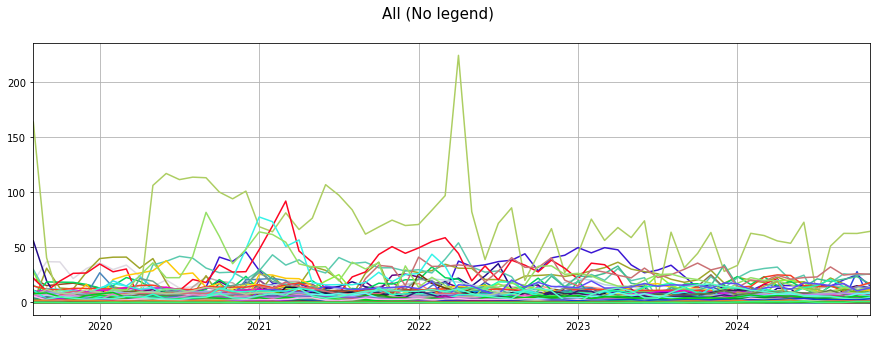

In [64]:
plot_multiple_ts(dtf, dates, color="ts", lst_colors=None, legend=False, title="All (No legend)", figsize=(15,5))

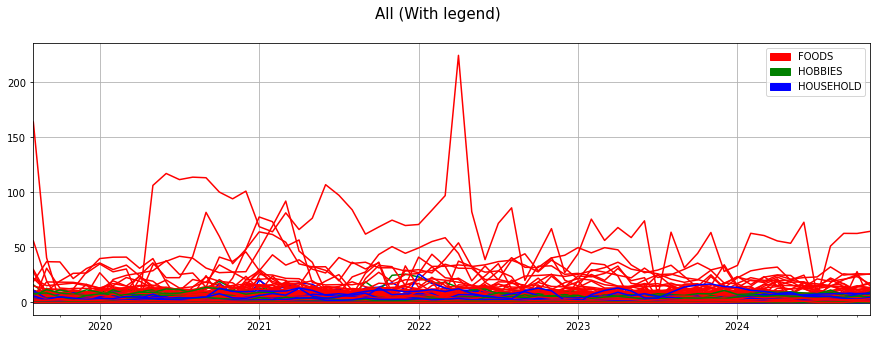

In [65]:
# Too many to spot a trend. Let's try to color by exog
plot_multiple_ts(dtf, dates, color='exog', lst_colors=["red", "green", "blue"], legend=True, title="All (With legend)", figsize=(15,5))

In [66]:
# Can the series be grouped by exog
# Extract means
dtf_sum= summarize_multiple_ts(dtf, by="exog", aggs=["mean"], return_all=False)
dtf_sum

--- rows from: 1000 --> to: 3 ---


,ts,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,FOODS_mean,1.658898,1.305720,1.085703,1.081780,1.066225,1.218494,1.279369,1.389420,1.330579,...,1.987873,2.012097,2.072034,1.921473,1.872881,1.609964,1.991320,2.093573,2.068412,2.092602
1,HOBBIES_mean,0.602941,0.590523,0.520082,0.563725,0.591872,0.599937,0.586714,0.581752,0.638072,...,0.685936,0.762018,0.728758,0.762966,0.760458,0.771189,0.744307,0.716503,0.675680,0.710580
2,HOUSEHOLD_mean,0.530864,0.431070,0.431900,0.436111,0.419853,0.458483,0.477011,0.490542,0.468827,...,0.816731,0.856432,0.805453,0.839705,0.796811,0.760554,0.781760,0.891770,0.826663,0.895062


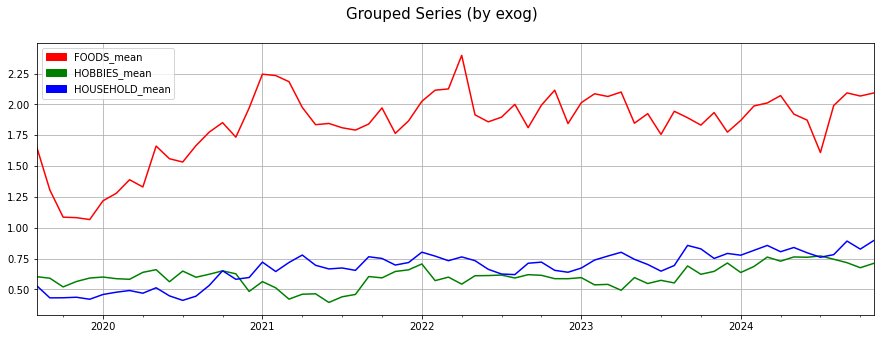

In [67]:
plot_multiple_ts(dtf_sum, dates, color="ts", lst_colors=["red", "green", "blue"], legend=True, title="Grouped Series (by exog)", figsize=(15,5))

In [68]:
# It's more clear now, there is a visual pattern. But can those means be used as proxy for the series?
# Let's compare one mean with all the other series in the group (exog):
dtf_sum=summarize_multiple_ts(dtf[dtf["exog"]=="FOODS"], by=None, aggs=["mean"], return_all=True)
dtf.tail()

--- rows from: 472 --> to: 473 ---


,ts,exog,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
995,HOUSEHOLD_1_377,HOUSEHOLD,0.0,0.233333,0.419355,0.066667,0.000000,0.000000,0.000000,0.000000,...,0.206897,0.096774,0.166667,0.322581,0.233333,0.161290,0.354839,0.566667,0.354839,0.208333
996,HOBBIES_1_236,HOBBIES,0.0,0.000000,0.064516,0.800000,0.741935,1.258065,1.241379,0.387097,...,0.448276,0.483871,0.566667,0.645161,0.433333,0.161290,0.000000,0.000000,0.000000,0.000000
997,FOODS_2_221,FOODS,2.0,2.000000,2.290323,1.900000,1.806452,1.645161,0.931034,1.612903,...,1.103448,1.096774,1.633333,2.419355,0.533333,0.548387,1.258065,1.366667,1.225806,1.333333
998,HOBBIES_1_003,HOBBIES,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.172414,0.129032,0.000000,0.129032,0.233333,0.516129,0.548387,0.633333,0.290323,0.625000
999,FOODS_2_310,FOODS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.724138,0.709677,0.833333,0.741935,1.100000,0.000000,0.000000,0.000000,0.870968,0.708333


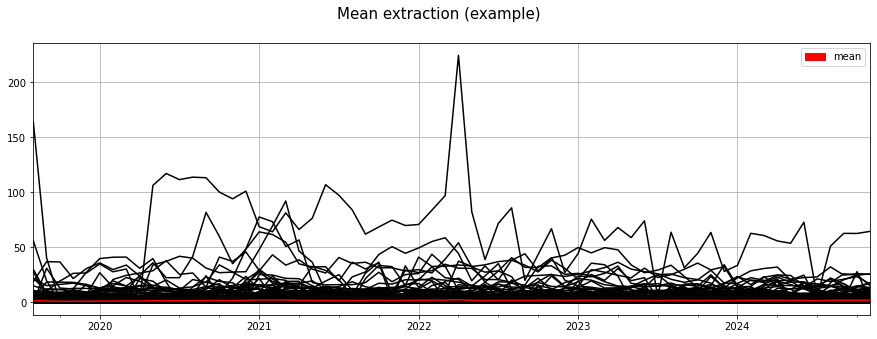

In [69]:
plot_multiple_ts(dtf_sum, dates, legend=True, lst_highlights=["mean"], 
                 title="Mean extraction (example)", figsize=(15,5))

In [70]:
# The mean is not representative of the group. So I'll find a new way of grouping the series with Clustering. 


#### Clustering

In [71]:
def utils_cluster_centers(cluster, center):
    scaler = preprocessing.StandardScaler()
    scaler.fit(cluster)
    return scaler.inverse_transform(center)

In [72]:
def clustering_multiple_ts(dtf, idxs, k=None, top=None, figsize=(10,5)):
    ## preprocessing
    dtf_c = dtf.copy()
    scaler = preprocessing.StandardScaler()
    lst_ts = []
    for name in dtf_c["ts"].unique():
        ts = utils_filter_ts(dtf_c, name, idxs)
        ts[ts.columns[0]] = scaler.fit_transform(ts)
        lst_ts.append(ts)

    ## hierarchical clustering
    if k is None:
        print("--- k not defined: using hierarchical clustering ---")
        dtw_sim = utils_dtw_dist(lst_ts, return_sim=False)
        ward_links = sci_cluster.hierarchy.ward(dtw_sim)
        max_dist_allowed_inside_clusters = dtw_sim.mean().mean()*dtw_sim.max().max()/dtw_sim.min().min()
        clusters = sci_cluster.hierarchy.fcluster(ward_links, t=max_dist_allowed_inside_clusters, criterion='distance')
        print("--- found", len(np.unique(clusters)), "clusters ---")
    
    ## k-means
    else:
        print("---", "k="+str(k)+": using k-means ---")
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw")
        clusters = model.fit_predict(to_time_series_dataset(lst_ts))
        
        
        

    ## put in the dtf
    other_cols = dtf_c.drop(idxs, axis=1).columns
    dtf_c["cluster"] = clusters

    ## plot freq
    ax = dtf_c["cluster"].value_counts().head(top).sort_values().plot(kind="barh", title="Cluster distribution", figsize=figsize)
    total = sum([i.get_width() for i in ax.patches])
    for i in ax.patches:
        ax.text(i.get_width()+.3, i.get_y()+.10, 
                str(i.get_width())+" ("+str(round((i.get_width()/total)*100,2))+'%)', 
                fontsize=10, color='black')
    ax.set(xlim=[0, dtf_c["cluster"].value_counts().max()+dtf_c["cluster"].value_counts().mean()])
    ax.grid(axis="x")
    plt.show()
    return dtf_c[list(other_cols)+["cluster"]+idxs]

In [74]:
# Find clusters
dtf_c = clustering_multiple_ts(dtf, dates, k=None, top=10, figsize=(15,5))

--- k not defined: using hierarchical clustering ---


KeyboardInterrupt: 

--- k=10: using k-means ---


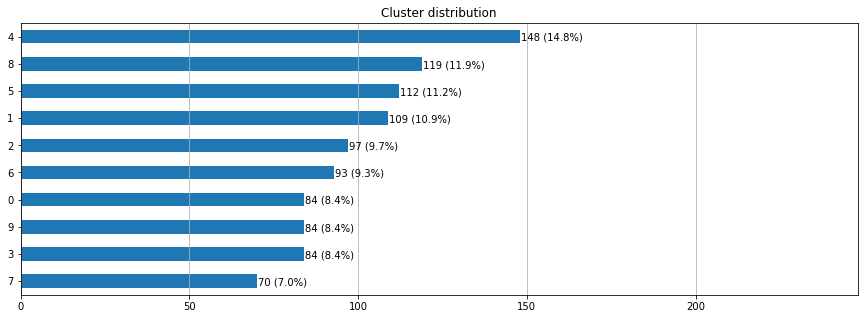

In [75]:
dtf_c = clustering_multiple_ts(dtf, dates, k=10, figsize=(15,5))

In [76]:
dtf_c.head()

,ts,exog,cluster,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,FOODS_3_536,FOODS,3,3.0,1.500000,1.774194,1.366667,2.032258,0.806452,1.206897,...,0.758621,1.225806,1.733333,1.258065,1.166667,1.000000,1.322581,1.066667,0.870968,1.541667
1,FOODS_3_382,FOODS,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.896552,1.354839,0.800000,0.322581,0.133333,0.548387,1.225806,2.033333,28.032258,0.416667
2,HOUSEHOLD_1_375,HOUSEHOLD,9,1.0,1.033333,1.096774,0.766667,0.677419,0.870968,0.896552,...,0.275862,0.483871,0.533333,0.709677,0.433333,0.290323,0.709677,0.733333,0.387097,0.666667
3,FOODS_2_084,FOODS,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.068966,1.903226,1.733333,1.483871,1.700000,0.580645,1.129032,1.100000,1.516129,1.958333
4,FOODS_3_668,FOODS,3,22.0,15.266667,16.451613,17.533333,15.258065,13.064516,10.724138,...,11.172414,11.548387,9.600000,7.806452,7.933333,9.258065,6.322581,6.300000,6.935484,7.750000


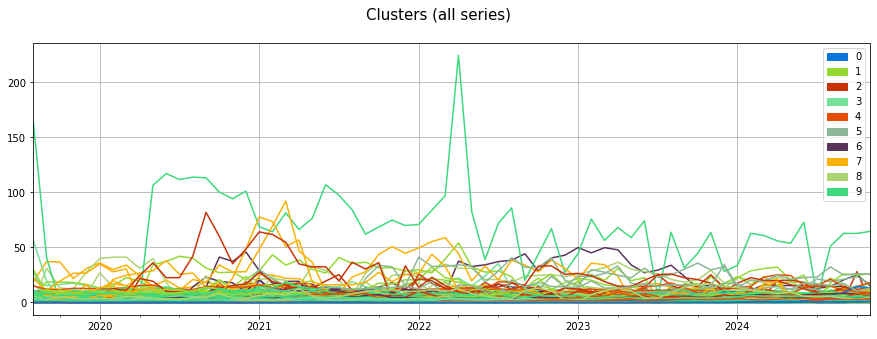

In [77]:
# Plot all clusters
plot_multiple_ts(dtf_c, dates, color="cluster", lst_colors=None, legend=True, 
                 title="Clusters (all series)", figsize=(15,5))

In [ ]:
# Check single cluster
c = 1

In [ ]:
dtf_sum = summarize_multiple_ts(dtf_c[dtf_c["cluster"]==c], by=None, aggs=["mean"], return_all=True)
dtf_sum.tail()

In [ ]:
plot_multiple_ts(dtf_sum, dates, legend=True, lst_highlights=["mean"], 
                 title="Cluster "+str(c)+" (Mean vs All)", figsize=(15,5))

In [ ]:
# Sum each cluster
dtf_sum = summarize_multiple_ts(dtf_c, by="cluster", aggs=["mean"], return_all=False)
dtf_sum

In [ ]:
# Plot clusters
plot_multiple_ts(dtf_sum, dates, color="ts", lst_colors=None, legend=True, 
                 title="Grouped series (by cluster)", figsize=(15,5))

#### Preprocessing

In [ ]:
# By Rows
dtf_train, dtf_test = split_multiple_train_test(dtf_c, idxs=None, test_size=0.2, idx_split=None)
print("train:", dtf_train.shape, "| test:", dtf_test.shape)

In [ ]:
dtf_test.head()

In [ ]:
# By Columns
dtf_train, dtf_test = split_multiple_train_test(dtf_c, idxs=dates, test_size=0.2, idx_split=None)
print("train:", dtf_train.shape, "| test:", dtf_test.shape)

In [ ]:
dtf_test.head()